<a href="https://colab.research.google.com/github/purvanshiporwal0609/PRODIGY_GA_1/blob/main/PRODIGY_GA_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
!tar -xzf facades.tar.gz


--2025-07-15 15:36:36--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tinghuiz.github.io/projects/pix2pix/datasets/facades.tar.gz [following]
--2025-07-15 15:36:37--  https://tinghuiz.github.io/projects/pix2pix/datasets/facades.tar.gz
Resolving tinghuiz.github.io (tinghuiz.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to tinghuiz.github.io (tinghuiz.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-15 15:36:37 ERROR 404: Not Found.

tar (child): facades.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recove

In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt


In [ ]:
class FacadeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = sorted(os.listdir(root_dir))
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, self.files[idx]))
        w, h = image.size
        input_image = image.crop((0, 0, w // 2, h))
        target_image = image.crop((w // 2, 0, w, h))

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

    def __len__(self):
        return len(self.files)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = FacadeDataset('facades/train', transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


In [ ]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        self.down1 = self.block(in_channels, 64, down=True, bn=False)
        self.down2 = self.block(64, 128, down=True)
        self.down3 = self.block(128, 256, down=True)
        self.down4 = self.block(256, 512, down=True)
        self.up1 = self.block(512, 256, down=False)
        self.up2 = self.block(512, 128, down=False)
        self.up3 = self.block(256, 64, down=False)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def block(self, in_c, out_c, down=True, bn=True):
        layers = []
        if down:
            layers.append(nn.Conv2d(in_c, out_c, 4, 2, 1))
        else:
            layers.append(nn.ConvTranspose2d(in_c, out_c, 4, 2, 1))
        if bn:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.ReLU() if not down else nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        u1 = self.up1(d4)
        u2 = self.up2(torch.cat([u1, d3], 1))
        u3 = self.up3(torch.cat([u2, d2], 1))
        return self.final(torch.cat([u3, d1], 1))


In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=6):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], 1))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = UNetGenerator().to(device)
D = PatchDiscriminator().to(device)

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoch in range(5):  # Keep small for testing
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Train Discriminator
        fake_y = G(x)
        real_labels = torch.ones_like(D(x, y)).to(device)
        fake_labels = torch.zeros_like(D(x, fake_y.detach())).to(device)

        loss_D_real = criterion_GAN(D(x, y), real_labels)
        loss_D_fake = criterion_GAN(D(x, fake_y.detach()), fake_labels)
        loss_D = (loss_D_real + loss_D_fake) * 0.5

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        output = D(x, fake_y)
        loss_G_GAN = criterion_GAN(output, real_labels)
        loss_G_L1 = criterion_L1(fake_y, y) * 100
        loss_G = loss_G_GAN + loss_G_L1

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch {epoch}, Step {i}, D Loss: {loss_D.item()}, G Loss: {loss_G.item()}")


Epoch 0, Step 0, D Loss: 0.7117801308631897, G Loss: 69.87476348876953
Epoch 0, Step 100, D Loss: 0.18763478100299835, G Loss: 20.770605087280273
Epoch 0, Step 200, D Loss: 0.07969298958778381, G Loss: 22.888404846191406
Epoch 0, Step 300, D Loss: 0.007572152651846409, G Loss: 31.873432159423828
Epoch 1, Step 0, D Loss: 0.00804231595247984, G Loss: 21.31294822692871
Epoch 1, Step 100, D Loss: 0.005273874849081039, G Loss: 29.866891860961914
Epoch 1, Step 200, D Loss: 0.005990244448184967, G Loss: 29.117910385131836
Epoch 1, Step 300, D Loss: 0.009670712053775787, G Loss: 27.572128295898438
Epoch 2, Step 0, D Loss: 0.011281007900834084, G Loss: 34.92795181274414
Epoch 2, Step 100, D Loss: 0.005929403472691774, G Loss: 34.032649993896484
Epoch 2, Step 200, D Loss: 0.0012105605565011501, G Loss: 27.79974937438965
Epoch 2, Step 300, D Loss: 1.622252345085144, G Loss: 24.441864013671875
Epoch 3, Step 0, D Loss: 0.003185002598911524, G Loss: 20.460105895996094
Epoch 3, Step 100, D Loss: 0.00

In [ ]:
G.eval()
import torchvision.utils as vutils

test_dataset = FacadeDataset('facades/test', transform)
test_loader = DataLoader(test_dataset, batch_size=1)

with torch.no_grad():
    for input_img, target_img in test_loader:
        input_img = input_img.to(device)
        fake_img = G(input_img)
        # Concatenate input, output, and real for comparison
        result = torch.cat([input_img.cpu(), fake_img.cpu(), target_img], dim=0)
        vutils.save_image(result, 'output_sample.png', nrow=3, normalize=True)
        break  # Only one sample


In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xzf facades.tar.gz

--2025-07-15 15:37:25--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M   400KB/s    in 66s     

2025-07-15 15:38:31 (446 KB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



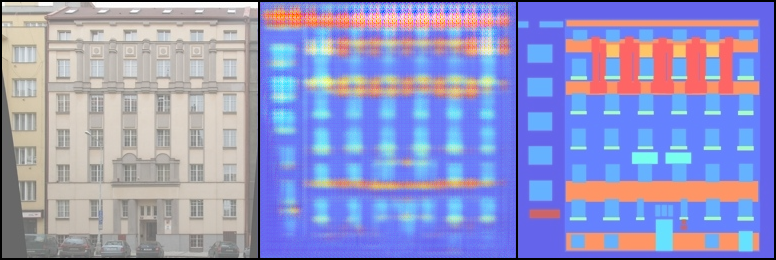

In [ ]:
from IPython.display import Image as IPImage
IPImage("output_sample.png")
